# Project 2: Topic Classification

## Author: Colby M. Carter
### Due Date: November 13, 2017

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\Colby\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Colby\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
num_test_half = int(round(num_test/2,0)) #previously indexing over a non-integer
test_data, test_labels = newsgroups_test.data[num_test_half:], newsgroups_test.target[num_test_half:]
dev_data, dev_labels = newsgroups_test.data[:num_test_half], newsgroups_test.target[:num_test_half]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('test data shape:', len(test_data))
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
test data shape: 677
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):

### STUDENT START ###
    for i in range(num_examples):
        print("Example #",(i+1),":")
        print("Label =",train_labels[i],"("+categories[train_labels[i]]+")\n")
        print(train_data[i])
        print("\n"+"*"*80+"\n")

### STUDENT END ###

P1()

Example # 1 :
Label = 1 (talk.religion.misc)

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

********************************************************************************

Example # 2 :
Label = 3 (sci.space)



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones,

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():

### STUDENT START ###
    """a) extract default features"""
    print("a)")
    vectorizer = CountVectorizer()
    out_vector = vectorizer.fit_transform(train_data)
    feature_count = out_vector.shape[1]
    print(" "*3, "{:.0f}".format(feature_count),"total features")
    avg_features = out_vector.getnnz(axis=1).mean()
    print(" "*3, "{:.1f}".format(avg_features) + " average non-zero features per example")
    pct_non_zero = out_vector.nnz / (out_vector.shape[0] * out_vector.shape[1])
    print(" "*3, "{:.4%}".format(pct_non_zero) + " of matrix entries are non-zero\n")
    
    
    """b) examples"""
    print("b)")
    feature_names = vectorizer.get_feature_names()
    print(" "*3, "First feature:",feature_names[0])
    print(" "*3, "Last feature:",feature_names[-1:])
    print()
    
    
    """c) four features only"""
    print("c)")
    vocab = ["atheism", "graphics", "space", "religion"]
    new_vector = CountVectorizer()
    new_vector.vocabulary = vocab
    out_vocab = new_vector.fit_transform(train_data)
    print(" "*3, "Features:", vocab)
    print(" "*3, "Confirm shape:", out_vocab.shape)
    avg_features = out_vocab.getnnz(axis=1).mean()
    print(" "*3, "{:.3f}".format(avg_features) + " average non-zero features per example\n")
    
    
    """d) bi- and trigrams only"""
    print("d)")
    mult_chars = CountVectorizer(analyzer="char", ngram_range=(2,3))
    out_mult = mult_chars.fit_transform(train_data)
    feature_count = out_mult.shape[1]
    print(" "*3, "{:.0f}".format(feature_count),"total features using bi- and trigrams only")
    mult_features = mult_chars.get_feature_names()
    #rand_ints = np.random.randint(len(mult_features), size=5)
    #print("Examples of bi- and tri-grams:")
    #for i in rand_ints:
    #    print(mult_features[i])
    print()

    
    """e) minimum of 10 doc occurences"""
    print("e)")
    min_10 = CountVectorizer(min_df=10)
    out_min10 = min_10.fit_transform(train_data)
    feature_count = out_min10.shape[1]
    print(" "*3, "{:.0f}".format(feature_count),"total features with min. 10 document occurences\n")
    
    
    """f) limiting train features to development vocab"""
    print("f)")
    dev_vector = CountVectorizer()
    out_dev = dev_vector.fit_transform(dev_data)
    dev_feature_count = out_dev.shape[1]
    dev_vocab = dev_vector.get_feature_names()
    print(" "*3,"Development set feature count:",dev_feature_count)
    
    #compare to train feature set
    intersection = len(set(feature_names).intersection(dev_vocab))
    dev_pct_missing = (dev_feature_count - intersection) / dev_feature_count
    print(" "*3, "{:.2%}".format(dev_pct_missing) + " of development vocab not in training vocab set") 
    
### STUDENT END ###

P2()

a)
    26879 total features
    96.7 average non-zero features per example
    0.3598% of matrix entries are non-zero

b)
    First feature: 00
    Last feature: ['zyxel']

c)
    Features: ['atheism', 'graphics', 'space', 'religion']
    Confirm shape: (2034, 4)
    0.268 average non-zero features per example

d)
    35478 total features using bi- and trigrams only

e)
    3064 total features with min. 10 document occurences

f)
    Development set feature count: 16246
    24.79% of development vocab not in training vocab set


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():

### STUDENT START ###
    print("3)")
    vectorizer = CountVectorizer()
    train_vocab = vectorizer.fit_transform(train_data)
    dev_vocab = vectorizer.transform(dev_data)
    print("Train shape:",train_vocab.shape)
    print("Development shape:",dev_vocab.shape,"\n")

    """k-nearest neighbors"""
    k_values = [i for i in range(1,250)] #test up to 250
    k_f1s = []
    for k in k_values:
        nbrs = KNeighborsClassifier(k)
        nbrs.fit(train_vocab, train_labels)
        nbrs_preds = nbrs.predict(dev_vocab)
        k_f1s.append(metrics.f1_score(dev_labels, nbrs_preds, average='micro'))
    print("KNN: the best performing k is","{:.0f}".format(k_values[np.argmax(k_f1s)]),"with f1 score =","{:.4f}".format(np.max(k_f1s)),"\n")
    
    """Multinomial Naive Bayes"""
    alphas = [0.00001, 0.0001, 0.001, .005, 0.01, .05, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
    nb_f1s = []
    for a in alphas:
        nb = MultinomialNB(alpha = a)
        nb.fit(train_vocab, train_labels)
        nb_preds = nb.predict(dev_vocab)
        nb_f1s.append(metrics.f1_score(dev_labels, nb_preds, average='micro'))
    #print(nb_f1s)
    print("MNB: the best performing alpha is","{:.2f}".format(alphas[np.argmax(nb_f1s)]),"with f1 score =","{:.4f}".format(np.max(nb_f1s)),"\n")
    
    """Logistic Regression"""
    c_values = [0.001, .005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0]
    lr_scores = []
    lr_weights_sq = []
    for c in c_values:
        log_reg = LogisticRegression(penalty="l2", C=c) #optimize by C
        log_reg.fit(train_vocab, train_labels)
        logit_preds = log_reg.predict(dev_vocab)
        lr_scores.append(metrics.f1_score(dev_labels, logit_preds, average='micro'))
        lr_weights_sq.append(np.sum(log_reg.coef_**2))
    print("Logistic: the best performing C is","{:.2f}".format(c_values[np.argmax(lr_scores)]),"with f1 score =","{:.4f}".format(np.max(lr_scores)))
    print("    Sum of squared coefficients by parameter C (part c.):")
    for i in range(0,len(c_values)):
        print("    C =", "{:.3f}".format(c_values[i]),":","{:.1f}".format(lr_weights_sq[i]))
    
### STUDENT END ###

P3()

3)
Train shape: (2034, 26879)
Development shape: (676, 26879) 

KNN: the best performing k is 112 with f1 score = 0.4867 

MNB: the best performing alpha is 0.10 with f1 score = 0.7929 

Logistic: the best performing C is 0.30 with f1 score = 0.7160
    Sum of squared coefficients by parameter C (part c.):
    C = 0.001 : 0.7
    C = 0.005 : 4.9
    C = 0.010 : 10.6
    C = 0.100 : 102.3
    C = 0.200 : 184.5
    C = 0.300 : 254.8
    C = 0.400 : 317.2
    C = 0.500 : 373.7
    C = 0.600 : 425.7
    C = 0.700 : 473.8
    C = 0.800 : 519.0
    C = 0.900 : 561.4
    C = 1.000 : 601.6
    C = 1.500 : 776.6
    C = 2.000 : 921.8
    C = 5.000 : 1514.2
    C = 10.000 : 2104.0


**ANSWER:**

(a) Nearest neighbors does not perform well for this problem because the features are not continuous numeric values. Instead, the presence of a word for a given observation is captured by a one, if not a zero. So, all distance computations are either one or zero, which is a low level of precision for determining a nearest neighbor.

(b) Because Naive Bayes assumes independence between the features, the model is not penalized for maximizing the number of word features. Logistic, on the other hand, likely suffers from overfitting by having more features than observations by an order of magnitude. These features likely add noise to the test label predictions, causing the higher error rate.

(c) The parameter C is the "inverse of regularization strength," so the more that regularized coefficients are desired, the lower the value for C needs to be. Thus, the relationship between the C and the sum of the squared weights is positive, where a smaller value for C reduces the size and thus the influence of the coefficients.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [6]:
def P4(vectorizer):

### STUDENT START ###
    """Train a logistic regression using input features and return a 20x4 table of top features and coefficients"""
    train_feats = vectorizer.fit_transform(train_data)
    train_vocab = vectorizer.get_feature_names()
    #print(train_feats.shape)
    #print(len(train_vocab))
    
    #train logistic and sort coefs
    logistic = LogisticRegression(penalty="l2", C=0.3) #c parameter from P3
    logistic.fit(train_feats, train_labels)
    coefs = logistic.coef_
    max_coefs = np.argsort(coefs, axis=1)[:,-5:] #order by ascending coefficient argument
    #print(max_coefs.shape)
    
    #store feature names for top five largest coefficients for each label
    top_features = []
    for label in range(max_coefs.shape[0]):
        by_feature = []
        for i in range(max_coefs.shape[1]):
            by_feature.append(train_vocab[max_coefs[label][i]])
        top_features.append(by_feature)
    features_ar = np.array(top_features)
    features_ar = np.reshape(features_ar,features_ar.shape[0] * features_ar.shape[1])
    #print(features_ar)
    print("Feature      ","Atheism  ", "Graphics", "Space   ", "Religion", sep="  ")
    for feat in features_ar:
        print(feat," "*(15-len(feat)),end="")
        index = train_vocab.index(feat)
        for label in range(0,4):
            print((6-len("{:.3f}".format(coefs[label][index])))*" "+"{:.3f}".format(coefs[label][index]), end=" "*4)
        print()


print("4)")
vectorizer = CountVectorizer()
print("One word features only:")
P4(vectorizer)

print("\nUsing bi-gram word features only:")
bigrams = CountVectorizer(analyzer="word", ngram_range=(2,2)) #with bi-gram words only
P4(bigrams)

4)
One word features only:
Feature        Atheism    Graphics  Space     Religion
islam            0.592    -0.098    -0.244    -0.247    
atheism          0.693    -0.304    -0.309    -0.340    
religion         0.693    -0.435    -0.568    -0.034    
atheists         0.702    -0.090    -0.231    -0.510    
bobby            0.707    -0.169    -0.247    -0.334    
computer         0.025     0.751    -0.489    -0.337    
3d              -0.263     0.811    -0.481    -0.273    
file            -0.239     0.916    -0.595    -0.428    
image           -0.395     0.956    -0.566    -0.323    
graphics        -0.562     1.413    -0.945    -0.536    
spacecraft      -0.256    -0.274     0.614    -0.235    
launch          -0.317    -0.347     0.679    -0.243    
nasa            -0.396    -0.360     0.744    -0.353    
orbit           -0.306    -0.482     0.869    -0.410    
space           -0.923    -0.978     1.660    -0.839    
order           -0.549    -0.056    -0.109     0.634    
fbi   

**ANSWER:** It's surprising that very generic bigrams such as "are you", "in this", and "but he" would be strong predictors, typically of either "Atheism"- or "Religion"-related messages. 

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [9]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):

### STUDENT START ###
    s = s.lower()
    s = re.sub("^\s[^A-Za-z0-9]+","",s) #special chars and white space
    s = re.sub("\d+", "#", s) #numeric seq to #
    s = re.sub("ly ", " ", s)
    s = re.sub("ing ", " ", s)
    # hurts classifier:
    #s = re.sub(";", " ", s)
    #s = re.sub(":", " ", s)
    #s = re.sub(r"[^\w]", " ",s) #remove paragraphs and tabs
    # s = re.sub("-", "", s)
    # if len(s)>10:
    #    s = s[0:10]
    
    return s

### STUDENT END ###


def P5(preprocessor, name):

### STUDENT START ###
    vectorizer = CountVectorizer(preprocessor = preprocessor)
    train_feats = vectorizer.fit_transform(train_data)
    print(name + " preprocessor:")
    print("Number of features:", len(vectorizer.get_feature_names()))
    
    logistic_proc = LogisticRegression(penalty="l2", C=.5)
    logistic_proc.fit(train_feats, train_labels)
    dev_vocab = vectorizer.transform(dev_data)
    logistic_preds = logistic_proc.predict(dev_vocab)
    print("F1 score:","{:.3f}".format(metrics.f1_score(dev_labels, logistic_preds, average='micro')))
    print()
    
    return len(vectorizer.get_feature_names())

### STUDENT END ###

count_1 = P5(empty_preprocessor, "Empty")
count_2 = P5(better_preprocessor, "Better")

print("Number of features reduced by", "{:.0f}".format(count_1-count_2),"("+"{:.1f}".format(100*(count_1-count_2)/count_1)+"%)")

Empty preprocessor:
Number of features: 33291
F1 score: 0.712

Better preprocessor:
Number of features: 24142
F1 score: 0.720

Number of features reduced by 9149 (27.5%)


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [10]:
def P6(c=.3):

    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)

    ### STUDENT START ###
    vectorizer = CountVectorizer()
    train_feats = vectorizer.fit_transform(train_data)
    
    #train with L1 regularization
    print("With L1 regularization (c = ",c,"):", sep="")
    logit_l1 = LogisticRegression(penalty="l1", C=c)
    logit_l1.fit(train_feats, train_labels)
    non_zero_l1 = np.count_nonzero(np.count_nonzero(logit_l1.coef_, axis=0))
    print(" "*4+"Non-zero coefficients =", non_zero_l1)
    dev_vocab = vectorizer.transform(dev_data)
    logit_l1_preds = logit_l1.predict(dev_vocab)
    print(" "*4+"F1 score =","{:.3f}".format(metrics.f1_score(dev_labels, logit_l1_preds, average='micro')))
    print()
    
    #with L2 regularization
    print("With L2 regularization:")
    logit_l2 = LogisticRegression(penalty="l2", C=c)
    logit_l2.fit(train_feats, train_labels)
    non_zero_l2 = np.count_nonzero(np.count_nonzero(logit_l2.coef_, axis=0))
    print(" "*4+"Non-zero coefficients =",non_zero_l2)
    logit_l2_preds = logit_l2.predict(dev_vocab)
    print(" "*4+"F1 score =","{:.3f}".format(metrics.f1_score(dev_labels, logit_l2_preds, average='micro')),"\n")
    
    print("There are","{:.0f}".format(non_zero_l2-non_zero_l1),"("+"{:.3f}".format(100*(non_zero_l2-non_zero_l1)/non_zero_l2)+"%) fewer non-zero weights using L1 regularization")
    
    ### STUDENT END ###
    
P6()

With L1 regularization (c = 0.3):
    Non-zero coefficients = 504
    F1 score = 0.703

With L2 regularization:
    Non-zero coefficients = 26879
    F1 score = 0.716 

There are 26375 (98.125%) fewer non-zero weights using L1 regularization


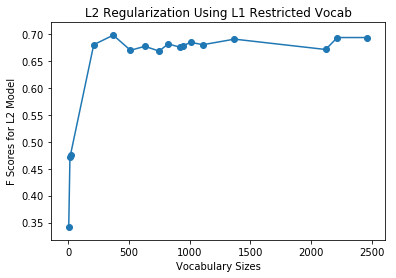

In [11]:
def P6_plot(c_array=[.3]):

    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)

    ### STUDENT START ###
    vectorizer_l1 = CountVectorizer()
    train_feats = vectorizer_l1.fit_transform(train_data)
    orig_vocab = vectorizer_l1.get_feature_names()
    vocab_sizes = []
    F1_scores = []
        
    for c in c_array:
        #train with L1 regularization
        logit_l1 = LogisticRegression(penalty="l1", C=c, tol = .01)
        logit_l1.fit(train_feats, train_labels)
        non_zero_l1 = np.count_nonzero(np.count_nonzero(logit_l1.coef_, axis=0))

        #reduce vocab list to that of L2 model
        new_vocab = []
        index = 0
        for feat in np.count_nonzero(logit_l1.coef_, axis=0):
            if feat > 0:
                new_vocab.append(orig_vocab[index])
            index+=1
        vocab_sizes.append(len(new_vocab))

        #retrain L2 model with restricted vocab
        vectorizer_l2 = CountVectorizer(vocabulary=new_vocab)
        train_feats_restr = vectorizer_l2.fit_transform(train_data)
        logit_restr = LogisticRegression(penalty="l2", C=c, tol = .01)
        logit_restr.fit(train_feats_restr, train_labels)
        dev_vocab = vectorizer_l2.transform(dev_data)
        preds = logit_restr.predict(dev_vocab)
        F1_scores.append(metrics.f1_score(dev_labels, preds, average='micro'))
    
    #print(vocab_sizes)
    #print(F1_scores)
    
    plt.plot(vocab_sizes, F1_scores)
    plt.scatter(vocab_sizes, F1_scores)
    plt.title('L2 Regularization Using L1 Restricted Vocab')
    plt.ylabel('F Scores for L2 Model') 
    plt.xlabel('Vocabulary Sizes')
    plt.show()


#c_array = [0.1, 0.2, 0.5, 1.0]
c_array = [0.001, .005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0]
P6_plot(c_array)

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [12]:
def P7():

### STUDENT START ###
    print("(7) Normalize matrix from CountVectorizer from raw counts to the term-frequency times inverse of document frequency:")
    alt_vector = TfidfVectorizer()
    alt_feats = alt_vector.fit_transform(train_data)
    # print(alt_feats.shape)
    
    logit_p7 = LogisticRegression(penalty="l2", C=100)
    logit_p7.fit(alt_feats, train_labels)
    dev_alt_feats = alt_vector.transform(dev_data)
    alt_preds = logit_p7.predict(dev_alt_feats)
    print("    - F1 score using normalized term frequency:","{:.3f}".format(metrics.f1_score(dev_labels, alt_preds, average='micro')))
    alt_probs = logit_p7.predict_proba(dev_alt_feats)
    #print(alt_probs[0:10,0:4])
    print("    - Maximum predicted probability:","{:.6f}".format(np.max(alt_probs)))
    max_prob = np.max(alt_probs)
    #max_probs = np.max(alt_probs, axis=1)
    #print(max_probs.shape)
    R_ratios = []
    for i in range(len(dev_labels)):
        R_ratios.append(max_prob / alt_probs[i,dev_labels[i]]) #R = max pred prob / pred prob of correct label
    #print(R_ratios[0:10])
    R_array = np.array(R_ratios)
    R_max = np.argsort(R_array)[-3:]
    print("    - Three highest R ratios:",["{:.1f}".format(R_ratios[r]) for r in R_max])
    print()
    example = 1
    for r in R_max:
        print("Example #", example, sep="",end=":\n")
        print("Correct label:", newsgroups_train.target_names[dev_labels[r]], \
              "(p_hat = {:.3f})".format(alt_probs[r,dev_labels[r]]), "\nPredicted:", \
              newsgroups_train.target_names[alt_preds[r]], "(p_hat = {:.3f})".format(np.max(alt_probs,axis=1)[r]), \
                "\n\n",dev_data[r], "\n\n"+"*"*80)
        example+=1

## STUDENT END ###

P7()

(7) Normalize matrix from CountVectorizer from raw counts to the term-frequency times inverse of document frequency:
    - F1 score using normalized term frequency: 0.763
    - Maximum predicted probability: 0.999979
    - Three highest R ratios: ['331.7', '412.9', '935.2']

Example #1:
Correct label: talk.religion.misc (p_hat = 0.003) 
Predicted: comp.graphics (p_hat = 0.980) 

 Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

********************************************************************************
Example #2:
Correct label: alt.atheism (p_hat = 0.002) 
Predicted: talk.religion.misc (p_hat = 0.695) 

 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 

********************************************************************************
Example #3:
Correct label: talk.religion.misc (p_hat = 0.001) 
Pred

**ANSWER:**
This model struggles when there is one or more keyword strongly tied to one of the (incorrect) labels that throws off the classifier from the main substance of the message. For example, the message with the highest R ratio has terms "ftp site," "online" and "internet address" which all aptly suggest computer graphics, but a quick reading of the email for "Book of Mormon" makes the message clearly about religion. To improve this, weights for certain keywords, such as "Book of Mormon," could be increased if those labels are routinely being missed, while other weights could be depressed. Additionally, if there are common pairings of keyword features, they could be interacted to form new variables, giving proper weight to the label that has both features present, e.g. "internet" and "Book of Mormon."

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.